In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !pip install daymetpy
# !pip install netCDF4
# !pip install pydap xarray matplotlib rasterio rioxarray shapely
# !pip install h5pyd



In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
import requests

from pydap.client import open_url
import xarray as xr
import time
import matplotlib.pyplot as plt
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping


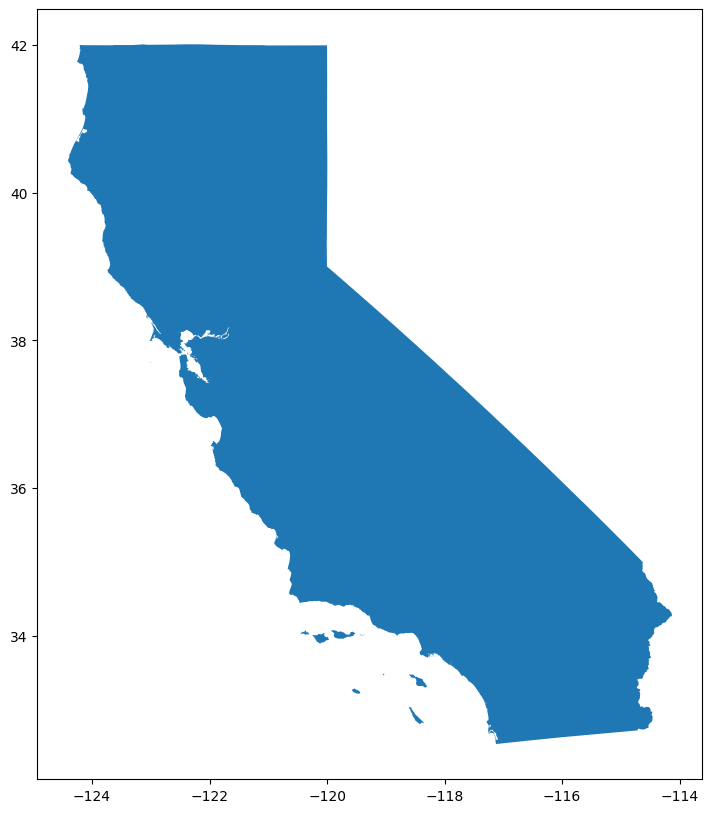

In [4]:
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax)
plt.show()


In [5]:
california_poly = california
california_poly_4326 = california_poly.to_crs(epsg=4326)
bbox = california_poly_4326.bounds.values.tolist()[0]


In [6]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2011, 1, 1)
var = 'prcp'


In [13]:
# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2129'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)


API Response: {'feed': {'updated': '2023-11-01T19:27:55.634Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2129', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:21.000Z', 'dataset_id': 'Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Daily_V4R1_2129', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 data as gridded estimates of daily weather parameters for North America, Hawaii, and Puerto Rico. Daymet variables include the following para

In [16]:
temporal_str = start_date.strftime('%Y-%m-%dT%H:%M:%SZ') + ',' + end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + '&page_size=1000&temporal=' + temporal_str + '&bounding_box[]=' + ','.join(map(str, bbox))
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']
granule_names = [g['title'] for g in granules if var in g['title']]
print("Granule Names:", granule_names)


Granule Names: ['Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2010.nc', 'Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2011.nc']


In [17]:
# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Define the bounding box for your area of interest
# (This is just an example, you should replace these values with the actual coordinates of your area of interest)
lccbounds = {
    'minx': -120.0,
    'maxx': -80.0,
    'miny': 30.0,
    'maxy': 50.0
}

before = time.time()
cnt = 0

# List of granule names (replace this with the actual list of files you want to process)
granule_names = ['file1.nc', 'file2.nc', 'file3.nc']

for g_name in granule_names:
    print(' ***GRANULE_NAME*** ---->', g_name)
    granule_dap = thredds_url + g_name
    print(granule_dap)

    # Using pydap's open_url
    thredds_ds = open_url(granule_dap)

    # Xarray DataSet - opening dataset via remote OPeNDAP
    ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")

    temp = ds[var].sel(x=slice(lccbounds['minx'], lccbounds['maxx']), y=slice(lccbounds['maxy'], lccbounds['miny']))

    if cnt == 0:
        prcp = temp
    else:
        prcp = xr.concat([prcp, temp], dim="time")

    cnt += 1

# save to netcdf
prcp.to_netcdf(var + '_tdssubset.nc')
print("Processing Time: ", time.time() - before, 'seconds')

 ***GRANULE_NAME*** ----> file1.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/file1.nc


HTTPError: ignored

In [18]:
import requests
import time
import xarray as xr
from pydap.client import open_url
from datetime import datetime

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Define the bounding box for your area of interest
# (This is just an example, you should replace these values with the actual coordinates of your area of interest)
lccbounds = {
    'minx': -120.0,
    'maxx': -80.0,
    'miny': 30.0,
    'maxy': 50.0
}

# Define the time range for your analysis
start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 12, 31)

# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2131'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)
    concept_id = None

if concept_id:
    temporal_str = start_date.strftime('%Y-%m-%dT%H:%M:%SZ') + ',' + end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    bbox = [lccbounds['minx'], lccbounds['miny'], lccbounds['maxx'], lccbounds['maxy']]
    granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + '&page_size=1000&temporal=' + temporal_str + '&bounding_box[]=' + ','.join(map(str, bbox))
    response = requests.get(granulesearch)
    granules = response.json()['feed']['entry']
    granule_names = [g['title'] for g in granules if var in g['title']]
    print("Granule Names:", granule_names)
else:
    granule_names = []

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

before = time.time()
cnt = 0

for g_name in granule_names:
    try:
        print(' ***GRANULE_NAME*** ---->', g_name)
        granule_dap = thredds_url + g_name
        print(granule_dap)

        # Using pydap's open_url
        thredds_ds = open_url(granule_dap)

        # Xarray DataSet - opening dataset via remote OPeNDAP
        ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")

        temp = ds[var].sel(x=slice(lccbounds['minx'], lccbounds['maxx']), y=slice(lccbounds['maxy'], lccbounds['miny']))

        if cnt == 0:
            prcp = temp
        else:
            prcp = xr.concat([prcp, temp], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred:", str(e))

if cnt > 0:
    # save to netcdf
    prcp.to_netcdf(var + '_monthly_tdssubset.nc')
    print("Processing Time: ", time.time() - before, 'seconds')
else:
    print("No data processed.")


API Response: {'feed': {'updated': '2023-11-01T20:07:06.792Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2131', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:24.000Z', 'dataset_id': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Monthly_V4R1_2131', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 monthly climate summaries derived from Daymet Version 4 R1 daily data at a 1 km x 1 km spatial resolution for five Daymet variables: minimum 

In [8]:
# best guess for now

!pip install h5pyd
import requests
import time
import xarray as xr
import h5pyd

# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2131'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)
    exit()

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

# Define the range of years for which you want to download data
start_year = 1980
end_year = 2022

before = time.time()
cnt = 0

for year in range(start_year, end_year + 1):
    g_name = f'daymet_v4_{var}_monttl_na_{year}.nc'
    granule_dap = thredds_url + g_name
    print(' ***GRANULE_NAME*** ---->', g_name)
    print(granule_dap)

    try:
        # Using pydap's open_url
        thredds_ds = xr.open_dataset(granule_dap)

        if cnt == 0:
            data = thredds_ds
        else:
            data = xr.concat([data, thredds_ds], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred:", str(e))

if cnt > 0:
    # save to netcdf
    data.to_netcdf(var + '_monthly_data.nc')
    print("Processing Time: ", time.time() - before, 'seconds')
    print("Data saved to", var + '_monthly_data.nc')
else:
    print("No data processed.")


API Response: {'feed': {'updated': '2023-11-01T20:32:43.421Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2131', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:24.000Z', 'dataset_id': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Monthly_V4R1_2131', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 monthly climate summaries derived from Daymet Version 4 R1 daily data at a 1 km x 1 km spatial resolution for five Daymet variables: minimum 

In [26]:
import requests
import time
import xarray as xr
from pydap.client import open_url
from datetime import datetime

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Define the bounding box for your area of interest
# (This is just an example, you should replace these values with the actual coordinates of your area of interest)
lccbounds = {
    'minx': -120.0,
    'maxx': -80.0,
    'miny': 30.0,
    'maxy': 50.0
}

# Define the time range for your analysis
start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 12, 31)

# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2131'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)
    concept_id = None

if concept_id:
    temporal_str = start_date.strftime('%Y-%m-%dT%H:%M:%SZ') + ',' + end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    bbox = [lccbounds['minx'], lccbounds['miny'], lccbounds['maxx'], lccbounds['maxy']]
    granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + '&page_size=1000&temporal=' + temporal_str + '&bounding_box[]=' + ','.join(map(str, bbox))
    response = requests.get(granulesearch)
    granules = response.json()['feed']['entry']
    granule_names = [g['title'] for g in granules if var in g['title']]
    print("Granule Names:", granule_names)
else:
    granule_names = []

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

before = time.time()
cnt = 0

for g_name in granule_names:
    try:
        print(' ***GRANULE_NAME*** ---->', g_name)
        granule_dap = thredds_url + g_name
        print(granule_dap)

        # Using pydap's open_url
        thredds_ds = open_url(granule_dap)

        # Xarray DataSet - opening dataset via remote OPeNDAP
        ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")

        temp = ds[var].sel(x=slice(lccbounds['minx'], lccbounds['maxx']), y=slice(lccbounds['maxy'], lccbounds['miny']))

        if cnt == 0:
            prcp = temp
        else:
            prcp = xr.concat([prcp, temp], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred:", str(e))

if cnt > 0:
    # save to netcdf
    prcp.to_netcdf(var + '_monthly_tdssubset.nc')
    print("Processing Time: ", time.time() - before, 'seconds')
else:
    print("No data processed.")


API Response: {'feed': {'updated': '2023-11-01T20:25:07.963Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2131', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:24.000Z', 'dataset_id': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Monthly_V4R1_2131', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 monthly climate summaries derived from Daymet Version 4 R1 daily data at a 1 km x 1 km spatial resolution for five Daymet variables: minimum 

In [21]:
import requests
import time
import xarray as xr

# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2131'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)
    exit()

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

# Define the range of years for which you want to download data
start_year = 1980
end_year = 2022

before = time.time()
cnt = 0
data = None

for year in range(start_year, end_year + 1):
    g_name = f'daymet_v4_{var}_monttl_na_{year}.nc'
    granule_dap = thredds_url + g_name
    print(' ***GRANULE_NAME*** ---->', g_name)
    print(granule_dap)

    try:
        # Using xarray's open_dataset
        thredds_ds = xr.open_dataset(granule_dap)

        if data is None:
            data = thredds_ds
        else:
            data = xr.concat([data, thredds_ds], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred:", str(e))

if cnt > 0 and data is not None:
    # save to netcdf
    output_filename = var + '_monthly_data.nc'
    data.to_netcdf(output_filename)
    print("Processing Time: ", time.time() - before, 'seconds')
    print("Data saved to", output_filename)
else:
    print("No data processed.")


API Response: {'feed': {'updated': '2023-11-01T20:20:58.610Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2131', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:24.000Z', 'dataset_id': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Monthly_V4R1_2131', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 monthly climate summaries derived from Daymet Version 4 R1 daily data at a 1 km x 1 km spatial resolution for five Daymet variables: minimum 

In [9]:
!pip install h5pyd
import requests
import time
import xarray as xr
import h5pyd

# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2131'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
try:
    response = requests.get(doisearch)
    response.raise_for_status()  # This will raise an HTTPError if the HTTP request returned an unsuccessful status code
    response_json = response.json()
    print("API Response:", response_json)
except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
    exit()
except Exception as err:
    print(f"An error occurred: {err}")
    exit()

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)
    exit()

# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

# Define the range of years for which you want to download data
start_year = 1980
end_year = 2022

before = time.time()
cnt = 0

for year in range(start_year, end_year + 1):
    g_name = f'daymet_v4_{var}_monttl_na_{year}.nc'
    granule_dap = thredds_url + g_name
    print(' ***GRANULE_NAME*** ---->', g_name)
    print(granule_dap)

    try:
        # Using pydap's open_url
        thredds_ds = xr.open_dataset(granule_dap)

        if cnt == 0:
            data = thredds_ds
        else:
            data = xr.concat([data, thredds_ds], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred while processing", g_name, ":", str(e))

if cnt > 0:
    try:
        # save to netcdf
        data.to_netcdf(var + '_monthly_data.nc')
        print("Processing Time: ", time.time() - before, 'seconds')
        print("Data saved to", var + '_monthly_data.nc')
    except Exception as e:
        print("An error occurred while saving the data:", str(e))
else:
    print("No data processed.")


API Response: {'feed': {'updated': '2023-11-01T20:37:18.128Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2131', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:24.000Z', 'dataset_id': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Monthly_V4R1_2131', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 monthly climate summaries derived from Daymet Version 4 R1 daily data at a 1 km x 1 km spatial resolution for five Daymet variables: minimum 

In [10]:
import requests
from bs4 import BeautifulSoup

catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'

response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Filter the links to include only those that point to dataset-specific pages
dataset_links = [link['href'] for link in links if 'dataset=' in link['href']]

# Print the extracted links
for link in dataset_links:
    print(link)


catalog.html?dataset=2131
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1980.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1981.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1982.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1983.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1984.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1985.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1986.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1987.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1988.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1989.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1990.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1991.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1992.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1993.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1994.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_hi_1995.nc
catalog.html?dataset=2131/daym

In [12]:
import requests
from bs4 import BeautifulSoup
import time
import xarray as xr

# Step 1: Extract dataset-specific links from the THREDDS Catalog
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Filter the links to include only those that point to dataset-specific pages with 'prcp_monttl_pr'
dataset_links = [link['href'] for link in links if 'dataset=' in link['href'] and 'prcp_monttl_pr' in link['href']]

# Print the extracted links
for link in dataset_links:
    print(link)

# Step 2: Download and process the data
# Define the variable you are interested in (e.g., 'prcp' for precipitation)
var = 'prcp'

# Update the URL to point to the Monthly Climate Summaries dataset
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2131/'

before = time.time()
cnt = 0

for link in dataset_links:
    # Extract the dataset name from the link
    dataset_name = link.split('=')[-1].split('/')[-1]  # This line is modified
    granule_dap = thredds_url + dataset_name
    print(' ***GRANULE_NAME*** ---->', dataset_name)
    print(granule_dap)

    try:
        # Using xarray's open_dataset
        thredds_ds = xr.open_dataset(granule_dap)

        if cnt == 0:
            data = thredds_ds
        else:
            data = xr.concat([data, thredds_ds], dim="time")

        cnt += 1
    except Exception as e:
        print("An error occurred while processing", dataset_name, ":", str(e))

if cnt > 0:
    try:
        # save to netcdf
        data.to_netcdf(var + '_monthly_data.nc')
        print("Processing Time: ", time.time() - before, 'seconds')
        print("Data saved to", var + '_monthly_data.nc')
    except Exception as e:
        print("An error occurred while saving the data:", str(e))
else:
    print("No data processed.")



catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1950.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1951.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1952.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1953.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1954.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1955.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1956.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1957.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1958.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1959.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1960.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1961.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1962.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1963.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1964.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1965.nc
catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1966.

KeyboardInterrupt: ignored

In [13]:
import requests
from bs4 import BeautifulSoup

# Step 1: Extract dataset-specific links from the THREDDS Catalog
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page
links = soup.find_all('a', href=True)

# Filter the links to include only those that point to dataset-specific pages with 'prcp_monttl_pr'
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/' + link['href'] for link in links if 'dataset=' in link['href'] and 'prcp_monttl_pr' in link['href']]

# Print the extracted links
for link in dataset_links:
    print(link)


https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1950.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1951.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1952.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1953.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1954.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1955.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1956.nc
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=2131/daymet_v4_prcp_monttl_pr_1957.nc
https://thredds.daac.ornl.gov/thredds/catalog/or

In [18]:
import requests
import xarray as xr

# The URL of the dataset
data_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/daymet_v4_prcp_monttl_pr_2020.nc"

# Download the dataset
response = requests.get(data_url)
with open('dataset.nc', 'wb') as f:
    f.write(response.content)

# Load the dataset
ds = xr.open_dataset('dataset.nc')

# Perform your data processing here
# For example, to print the dataset's structure:
print(ds)


<xarray.Dataset>
Dimensions:                  (time: 12, nv: 2, y: 231, x: 364)
Coordinates:
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2020-01-16T12:00:00 ... 20...
  * x                        (x) float32 3.446e+06 3.447e+06 ... 3.809e+06
  * y                        (y) float32 -1.765e+06 -1.766e+06 ... -1.995e+06
Dimensions without coordinates: nv
Data variables:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 ...
Attributes:
    start_year:        2020
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.1
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current info